In [2]:
# Importy i ustawienia
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib    # do zapisu scalerów
import json
import os

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Ścieżki
ROOT = Path("..")            # jeśli notebook w notebooks/
RAW_DIR = ROOT / "data" / "raw"
PROC_DIR = ROOT / "data" / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)

# Parametry ogólne
CRYPTO = ["BTC", "ETH"]   # pliki: BTC_daily.csv, ETH_daily.csv
DATE_COL = "Date"
TARGET_COL = "Close"      # co chcemy prognozować


In [1]:
!pip install yfinance --quiet


  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import yfinance as yf

# Lista kryptowalut i ich tickery z Yahoo Finance
TICKERS = {
    "BTC": "BTC-USD",
    "ETH": "ETH-USD"
}

# Folder, gdzie zapiszemy dane
RAW_DIR.mkdir(parents=True, exist_ok=True)

# Zakres dat (np. od 2018 roku do dziś)
START_DATE = "2018-01-01"
END_DATE = None   # None = do dziś

for symbol, ticker in TICKERS.items():
    print(f"Pobieranie danych dla {symbol} ({ticker})...")
    df = yf.download(ticker, start=START_DATE, end=END_DATE, interval="1d")
    df.reset_index(inplace=True)  # przenosi Date z indexu do kolumny
    out_path = RAW_DIR / f"{symbol}_daily.csv"
    df.to_csv(out_path, index=False)
    print(f"Zapisano: {out_path} ({len(df)} wierszy)")


Pobieranie danych dla BTC (BTC-USD)...


C:\Users\radon\AppData\Local\Temp\ipykernel_57088\3750733617.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE, interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\radon\AppData\Local\Temp\ipykernel_57088\3750733617.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE, interval="1d")


Zapisano: ..\data\raw\BTC_daily.csv (2857 wierszy)
Pobieranie danych dla ETH (ETH-USD)...


[*********************100%***********************]  1 of 1 completed

Zapisano: ..\data\raw\ETH_daily.csv (2857 wierszy)


In [5]:
# Wczytanie danych surowych
def clean_data(df):
    # Usuń pierwszy wiersz jeśli zawiera tekst (np. 'BTC-USD')
    if df.iloc[0].astype(str).str.contains("BTC-USD|ETH-USD").any():
        df = df.drop(0).reset_index(drop=True)

    # Zamień kolumny na typ numeryczny (oprócz Date)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Usuń ewentualne wiersze z NaN po konwersji
    df.dropna(inplace=True)

    # Upewnij się, że kolumna Date jest typu datetime
    df["Date"] = pd.to_datetime(df["Date"])

    # Posortuj po dacie
    df.sort_values("Date", inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

# Wczytaj dane jeszcze raz i wyczyść
btc = pd.read_csv(RAW_DIR / "BTC_daily.csv")
eth = pd.read_csv(RAW_DIR / "ETH_daily.csv")

btc = clean_data(btc)
eth = clean_data(eth)

print(btc.info())
print(btc.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2857 entries, 0 to 2856
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2857 non-null   datetime64[ns]
 1   Close   2857 non-null   float64       
 2   High    2857 non-null   float64       
 3   Low     2857 non-null   float64       
 4   Open    2857 non-null   float64       
 5   Volume  2857 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 134.0 KB
None
        Date         Close          High           Low          Open  \
0 2018-01-01  13657.200195  14112.200195  13154.700195  14112.200195   
1 2018-01-02  14982.099609  15444.599609  13163.599609  13625.000000   
2 2018-01-03  15201.000000  15572.799805  14844.500000  14978.200195   
3 2018-01-04  15599.200195  15739.700195  14522.200195  15270.700195   
4 2018-01-05  17429.500000  17705.199219  15202.799805  15477.200195   

        Volume  
0  10291200000  

In [6]:
btc.describe()


,Date,Close,High,Low,Open,Volume
count,2857,2857.000000,2857.000000,2857.000000,2857.000000,2.857000e+03
mean,2021-11-29 00:00:00,35992.285276,36679.137308,35201.285886,35958.257489,2.954968e+10
min,2018-01-01 00:00:00,3236.761719,3275.377930,3191.303467,3236.274658,2.923670e+09
25%,2019-12-16 00:00:00,9360.879883,9531.490234,9230.776367,9352.393555,1.505308e+10
50%,2021-11-29 00:00:00,26819.972656,27155.158203,26415.515625,26807.769531,2.580285e+10
75%,2023-11-13 00:00:00,54815.078125,56610.312500,53319.187500,54734.125000,3.879986e+10
max,2025-10-27 00:00:00,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11
std,NaN,31403.426790,31890.436342,30836.461285,31371.657986,2.147763e+10


In [7]:
def add_features(df):
    # Dzienna zmiana procentowa ceny
    df["Return"] = df["Close"].pct_change()

    # Średnie kroczące
    df["MA7"] = df["Close"].rolling(window=7).mean()
    df["MA14"] = df["Close"].rolling(window=14).mean()
    df["MA30"] = df["Close"].rolling(window=30).mean()

    # Różnice między ceną a średnimi
    df["Diff_MA7"] = df["Close"] - df["MA7"]
    df["Diff_MA30"] = df["Close"] - df["MA30"]

    # Logarytmiczny wolumen (żeby znormalizować duże liczby)
    df["Log_Volume"] = np.log(df["Volume"] + 1)

    # Usuwamy pierwsze wiersze, gdzie średnie są puste
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

btc = add_features(btc)
eth = add_features(eth)

print(btc.head())


        Date         Close          High           Low          Open  \
0 2018-01-30  10106.299805  11307.200195  10036.200195  11306.799805   
1 2018-01-31  10221.099609  10381.599609   9777.419922  10108.200195   
2 2018-02-01   9170.540039  10288.799805   8812.280273  10237.299805   
3 2018-02-02   8830.750000   9142.280273   7796.490234   9142.280273   
4 2018-02-03   9174.910156   9430.750000   8251.629883   8852.120117   

        Volume    Return           MA7          MA14          MA30  \
0   8637859840 -0.105352  11202.843052  11356.421596  13181.040039   
1   8041160192  0.011359  11040.228655  11287.314453  13066.503353   
2   9959400448 -0.102783  10741.820033  11122.717285  12872.784701   
3  12726899712 -0.037052  10407.441406  10924.385114  12660.443034   
4   7263790080  0.038973  10083.757115  10658.364397  12446.300033   

      Diff_MA7    Diff_MA30  Log_Volume  
0 -1096.543248 -3074.740234   22.879421  
1  -819.129046 -2845.403743   22.807839  
2 -1571.279994 -3702

In [8]:
PROC_DIR.mkdir(parents=True, exist_ok=True)

btc.to_csv(PROC_DIR / "BTC_processed.csv", index=False)
eth.to_csv(PROC_DIR / "ETH_processed.csv", index=False)

print("Zapisano pliki:")
print(PROC_DIR / "BTC_processed.csv")
print(PROC_DIR / "ETH_processed.csv")

Zapisano pliki:
..\data\processed\BTC_processed.csv
..\data\processed\ETH_processed.csv


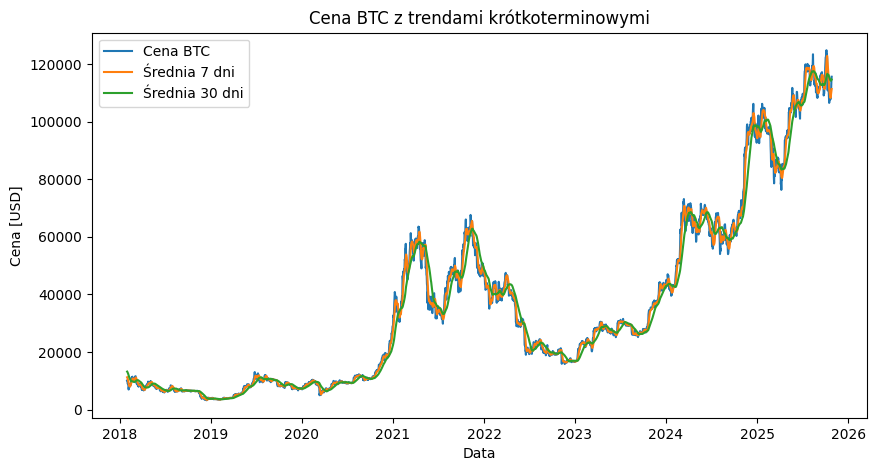

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(btc["Date"], btc["Close"], label="Cena BTC")
plt.plot(btc["Date"], btc["MA7"], label="Średnia 7 dni")
plt.plot(btc["Date"], btc["MA30"], label="Średnia 30 dni")
plt.title("Cena BTC z trendami krótkoterminowymi")
plt.xlabel("Data")
plt.ylabel("Cena [USD]")
plt.legend()
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np

# Kolumny, które chcemy wykorzystać jako dane wejściowe
FEATURES = ["Close", "Return", "MA7", "MA14", "MA30", "Diff_MA7", "Diff_MA30", "Log_Volume"]

# Dla pewności, że kolumny istnieją
btc_features = btc[FEATURES].copy()

# Zapiszmy liczby próbek
print("Liczba obserwacji:", len(btc_features))
btc_features.head()

Liczba obserwacji: 2828


,Close,Return,MA7,MA14,MA30,Diff_MA7,Diff_MA30,Log_Volume
0,10106.299805,-0.105352,11202.843052,11356.421596,13181.040039,-1096.543248,-3074.740234,22.879421
1,10221.099609,0.011359,11040.228655,11287.314453,13066.503353,-819.129046,-2845.403743,22.807839
2,9170.540039,-0.102783,10741.820033,11122.717285,12872.784701,-1571.279994,-3702.244661,23.021783
3,8830.750000,-0.037052,10407.441406,10924.385114,12660.443034,-1576.691406,-3829.693034,23.266984
4,9174.910156,0.038973,10083.757115,10658.364397,12446.300033,-908.846959,-3271.389876,22.706168


In [12]:
scaler = MinMaxScaler()
scaler.fit(btc_features)

btc_scaled = pd.DataFrame(scaler.transform(btc_features), columns=btc_features.columns)

# Zapisz scaler, żeby potem użyć go do testu
joblib.dump(scaler, PROC_DIR / "btc_scaler.save")

print("Dane przeskalowane 0–1 i zapisano scaler.")
btc_scaled.head()

Dane przeskalowane 0–1 i zapisano scaler.


,Close,Return,MA7,MA14,MA30,Diff_MA7,Diff_MA30,Log_Volume
0,0.056532,0.476327,0.065741,0.068265,0.084369,0.394372,0.353994,0.226263
1,0.057477,0.685054,0.064379,0.067668,0.083364,0.408178,0.360395,0.211313
2,0.048831,0.480921,0.061881,0.066244,0.081664,0.370745,0.336478,0.255997
3,0.046035,0.598474,0.059081,0.064529,0.079800,0.370476,0.332920,0.307210
4,0.048867,0.734438,0.056371,0.062228,0.077921,0.403713,0.348504,0.190077


In [13]:
def time_split(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test

train, val, test = time_split(btc_scaled)

print(f"Train: {len(train)} próbek")
print(f"Val:   {len(val)} próbek")
print(f"Test:  {len(test)} próbek")

Train: 1979 próbek
Val:   424 próbek
Test:  425 próbek


In [14]:
def create_sequences(data, window=30, target_col="Close"):
    X, y = [], []
    target_idx = data.columns.get_loc(target_col)
    for i in range(window, len(data)):
        X.append(data.iloc[i-window:i].values)
        y.append(data.iloc[i, target_idx])
    return np.array(X), np.array(y)

WINDOW = 30

X_train, y_train = create_sequences(train, window=WINDOW)
X_val, y_val = create_sequences(val, window=WINDOW)
X_test, y_test = create_sequences(test, window=WINDOW)

print("Kształty danych:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

Kształty danych:
X_train: (1949, 30, 8)
y_train: (1949,)


In [ ]:
#Zapisanie sekwencji do plików
np.save(PROC_DIR / "X_train.npy", X_train)
np.save(PROC_DIR / "y_train.npy", y_train)
np.save(PROC_DIR / "X_val.npy", X_val)
np.save(PROC_DIR / "y_val.npy", y_val)
np.save(PROC_DIR / "X_test.npy", X_test)
np.save(PROC_DIR / "y_test.npy", y_test)

print("Zapisano sekwencje do data/processed/")

Zapisano sekwencje do data/processed/


In [ ]:
#Import i wczytanie danych
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Wczytanie danych z poprzedniego etapu
X_train = np.load(PROC_DIR / "X_train.npy")
y_train = np.load(PROC_DIR / "y_train.npy")
X_val = np.load(PROC_DIR / "X_val.npy")
y_val = np.load(PROC_DIR / "y_val.npy")
X_test = np.load(PROC_DIR / "X_test.npy")
y_test = np.load(PROC_DIR / "y_test.npy")

print("Kształty danych:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

Kształty danych:
X_train: (1949, 30, 8)
y_train: (1949,)


In [ ]:
#Budowa modelu LSTM
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),   # np. (30, 8)
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # jedna wartość — przewidywana cena
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#trenowanie modelu
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0144 - mae: 0.0831 - val_loss: 0.0013 - val_mae: 0.0266
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.8038e-04 - mae: 0.0166 - val_loss: 0.0010 - val_mae: 0.0238
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7441e-04 - mae: 0.0149 - val_loss: 9.4527e-04 - val_mae: 0.0230
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.3273e-04 - mae: 0.0145 - val_loss: 8.3558e-04 - val_mae: 0.0217
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.3248e-04 - mae: 0.0128 - val_loss: 4.3131e-04 - val_mae: 0.0159
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0627e-04 - mae: 0.0124 - val_loss: 6.3874e-04 - val_mae: 0.0189
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.0010e-04 - mae: 0.0124 - val_loss: 4.0428e-04 - val_mae: 0.0161
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.5438e-04 - mae: 0.0114 - val_loss: 0.0010 - val_mae: 0.0247
Epoch 9/50
61/61

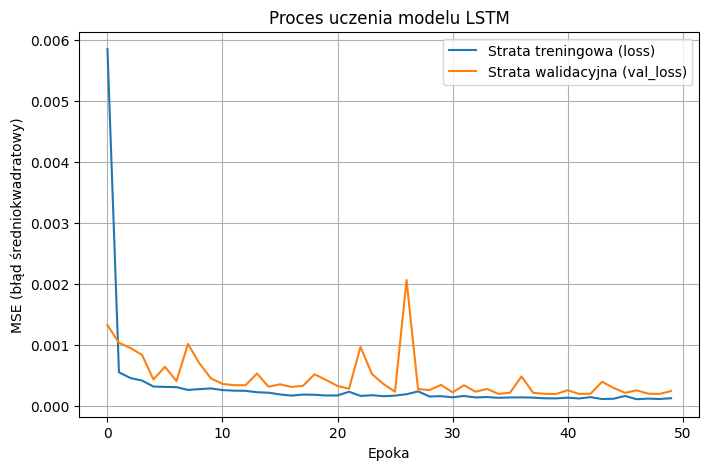

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Strata treningowa (loss)')
plt.plot(history.history['val_loss'], label='Strata walidacyjna (val_loss)')
plt.title("Proces uczenia modelu LSTM")
plt.xlabel("Epoka")
plt.ylabel("MSE (błąd średniokwadratowy)")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Prognozowanie na zbiorze testowym
y_pred = model.predict(X_test)

# Dla uproszczenia zamienimy na płaskie wektory
y_pred = y_pred.flatten()

print("Przykładowe prognozy (zeskalowane 0–1):")
print(y_pred[:10])

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Przykładowe prognozy (zeskalowane 0–1):
[0.49715877 0.50025666 0.5003524  0.48564756 0.46743143 0.46129027
 0.46018142 0.46869332 0.47315145 0.4810003 ]


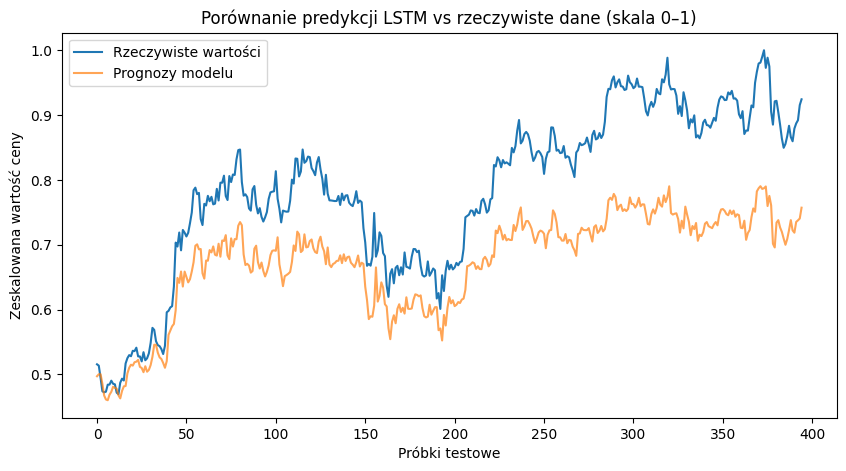

In [22]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Rzeczywiste wartości')
plt.plot(y_pred, label='Prognozy modelu', alpha=0.7)
plt.title("Porównanie predykcji LSTM vs rzeczywiste dane (skala 0–1)")
plt.xlabel("Próbki testowe")
plt.ylabel("Zeskalowana wartość ceny")
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE (skala 0–1): {rmse:.6f}")
print(f"MAE (skala 0–1): {mae:.6f}")

RMSE (skala 0–1): 0.121927
MAE (skala 0–1): 0.109756


In [ ]:
import joblib
import numpy as np

# Wczytaj scaler (ten, którym skalowałaś dane)
scaler = joblib.load(PROC_DIR / "btc_scaler.save")

# Znajdź indeks kolumny 'Close' (bo to była nasza kolumna docelowa)
n_features = X_train.shape[2]
close_index = 0  # pierwsza kolumna w FEATURES to 'Close'

def inverse_close(pred_scaled, true_scaled):
    # tworzymy macierze z zerami i wstawiamy prognozy w kolumnę 'Close'
    pred_full = np.zeros((len(pred_scaled), n_features))
    true_full = np.zeros((len(true_scaled), n_features))
    pred_full[:, close_index] = pred_scaled
    true_full[:, close_index] = true_scaled

    pred_usd = scaler.inverse_transform(pred_full)[:, close_index]
    true_usd = scaler.inverse_transform(true_full)[:, close_index]
    return pred_usd, true_usd

y_pred_usd, y_test_usd = inverse_close(y_pred, y_test)

print("Przykładowe prognozy w USD:")
print(y_pred_usd[:5])

Przykładowe prognozy w USD:
[63649.39172327 64025.83443019 64037.46653446 62250.59859177
 60037.0511581 ]


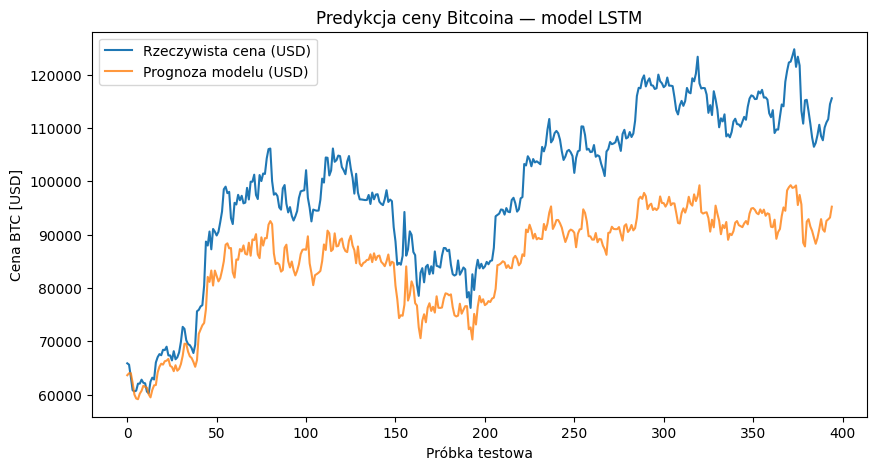

In [26]:
plt.figure(figsize=(10,5))
plt.plot(y_test_usd, label='Rzeczywista cena (USD)')
plt.plot(y_pred_usd, label='Prognoza modelu (USD)', alpha=0.8)
plt.title("Predykcja ceny Bitcoina — model LSTM")
plt.xlabel("Próbka testowa")
plt.ylabel("Cena BTC [USD]")
plt.legend()
plt.show()
